# Satellite Imagery Classification

- objective
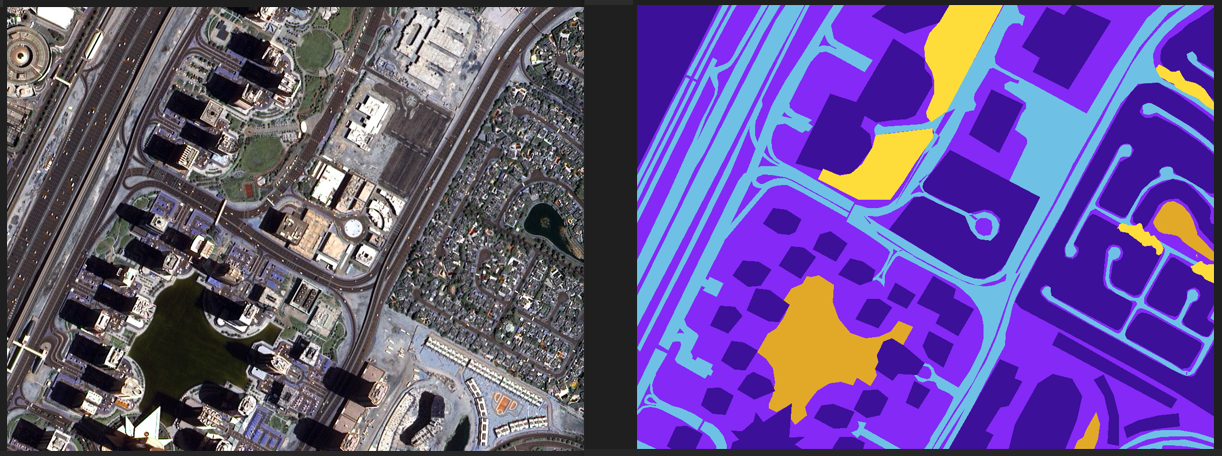
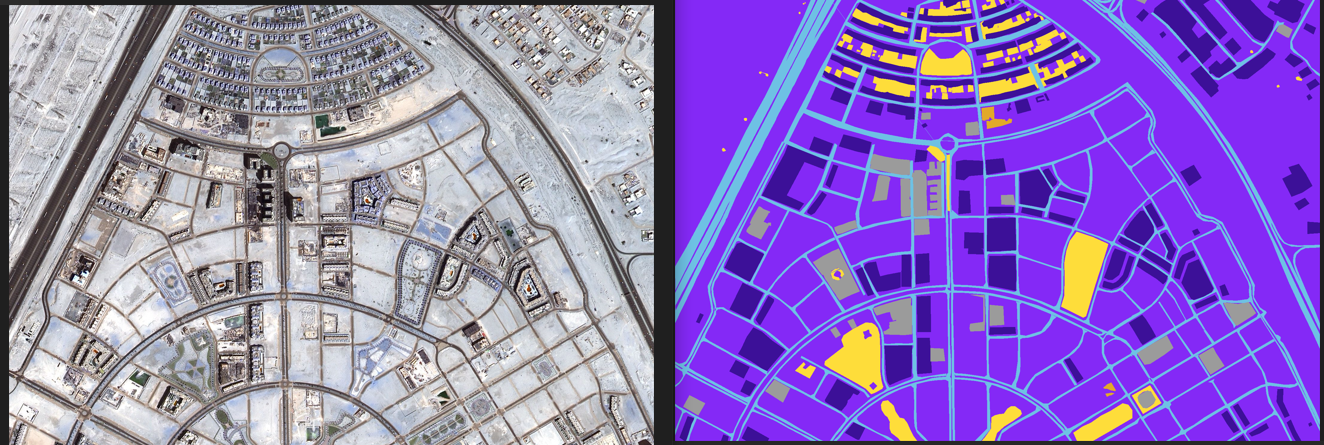

In [109]:
import os
import tensorflow as tf
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

# PART 1 data preprocessing

In [110]:
dataset_root_folder='dataset/'
dataset_name='dubai_dataset'

In [111]:
minmaxscalar=MinMaxScaler()

In [112]:
for path, subdir, files in os.walk(os.path.join(dataset_root_folder,dataset_name)):
    dir_name=path.split(os.path.sep)[-1]
    # print(dir_name)
    if dir_name == 'masks':
        images=os.listdir(path)
        # print(images)
        print(path)
        for i,image_name in enumerate(images):
            if (image_name.endswith('.png')): # mask image
                a=True
                # print(image_name)
    

dataset/dubai_dataset\Tile 1\masks
dataset/dubai_dataset\Tile 2\masks
dataset/dubai_dataset\Tile 3\masks
dataset/dubai_dataset\Tile 4\masks
dataset/dubai_dataset\Tile 5\masks
dataset/dubai_dataset\Tile 6\masks
dataset/dubai_dataset\Tile 7\masks
dataset/dubai_dataset\Tile 8\masks


In [113]:
# define patch size
image_patch_size=256

In [114]:
image=cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg',1)
image.shape

(544, 509, 3)

In [115]:
image_patches=patchify(image,(image_patch_size,image_patch_size,3),step=image_patch_size)

In [116]:
image_patches.shape

(2, 1, 1, 256, 256, 3)

In [117]:
imagex=image_patches[0,0,:,:]

imagey=minmaxscalar.fit_transform(imagex.reshape(-1,imagex.shape[-1])).reshape(imagex.shape)
imagey[0].shape

(256, 256, 3)

In [118]:
print(type(image))

<class 'numpy.ndarray'>


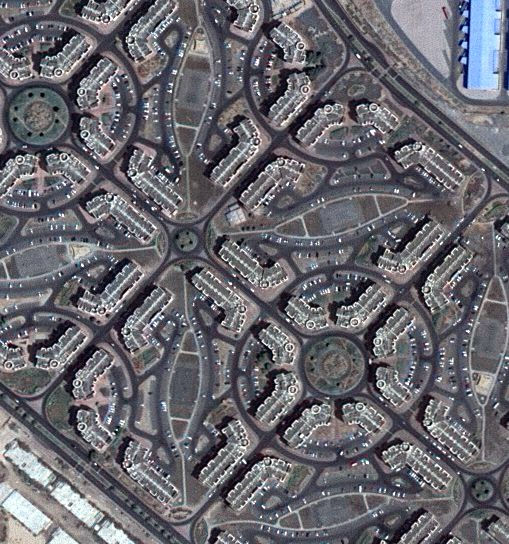

In [119]:
Image.fromarray(image)

In [120]:
(image.shape[0]//image_patch_size)*image_patch_size

512

# each image is of different shape

In [121]:
image_dataset=[]
mask_dataset=[]
 #png #jpg
for image_type in ['images','masks']:    #masks #images
    if image_type=='images':
        image_extension='jpg'
    elif image_type=='masks':
        image_extension='png'
    for tile_id in range(1,8):
        for image_id in range(1,20):
            image=cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
            if image is not None:

                if image_type=='masks':
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                # print(image.shape)
                size_x=(image.shape[1]//image_patch_size)*image_patch_size
                size_y=(image.shape[0]//image_patch_size)*image_patch_size
                # print('{}----{}-{}'.format(image.shape,size_x,size_y)) # multiples of 256
                image=Image.fromarray(image)
                image=image.crop((0,0,size_x,size_y))
                # print(f'{image.size[0]},{image.size[1]}')
                image=np.array(image)
                patched_images=patchify(image,(image_patch_size,image_patch_size,3),step=image_patch_size)
                # print(patched_images.shape)
                #get individual patched image
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        if image_type == 'images':
                            individual_patched_image=patched_images[i,j,:,:]
                            # print(individual_patched_image.shape)
                            individual_patched_image=minmaxscalar.fit_transform(individual_patched_image.reshape(-1,individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                            individual_patched_image=individual_patched_image[0]
                            # print(individual_patched_image.shape)
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask=patched_images[i,j,:,:]
                            individual_patched_mask=individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

In [122]:
image_dataset=np.array(image_dataset)
mask_dataset=np.array(mask_dataset)

In [123]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


# renderning the images

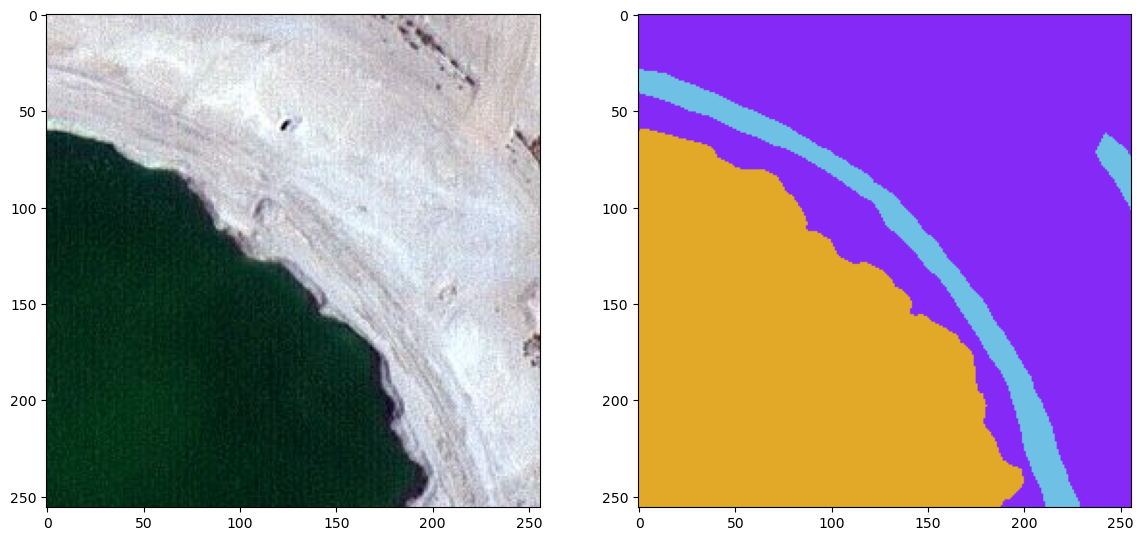

In [124]:
random_image_id=random.randint(0,len(image_dataset))
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

# Mask label processing
- color code to one-Hot encoding transformation
- after each image is transformed into
- 256x256x3 where 3 is RGB color code
- 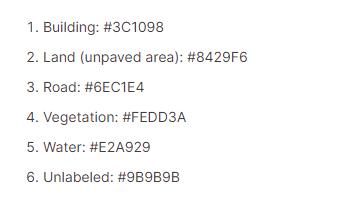

# python code to convert HEX value to RGB

In [125]:
class_building='#3C1098' # blue 
class_building=class_building.strip('#')
# 3C 10 98
class_building=np.array(tuple(int(class_building[i:i+2],16) for i in (0,2,4)))
print(class_building)

class_land='#8429F6' # purple
class_land=class_land.strip('#')
class_land=np.array(tuple(int(class_land[i:i+2],16) for i in (0,2,4)))
print(class_land)

class_road='#6EC1E4' # light blue
class_road=class_road.strip('#')
class_road=np.array(tuple(int(class_road[i:i+2],16) for i in (0,2,4)))
print(class_road)

class_vegetation='#FEDD3A' # yellow
class_vegetation=class_vegetation.strip('#')
class_vegetation=np.array(tuple(int(class_vegetation[i:i+2],16) for i in (0,2,4)))
print(class_vegetation)

class_water='#E2A929' # gold
class_water=class_water.strip('#')
class_water=np.array(tuple(int(class_water[i:i+2],16) for i in (0,2,4)))
print(class_water)

class_unlabeled='#9B9B9B' # silver
class_unlabeled=class_unlabeled.strip('#')
class_unlabeled=np.array(tuple(int(class_unlabeled[i:i+2],16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [126]:
mask_dataset.shape

(945, 256, 256, 3)

In [127]:
def rgb_to_label(label):
    label_segment=np.zeros(label.shape,dtype=np.uint8)
    label_segment[np.all(label == class_water,axis=-1)]=0
    label_segment[np.all(label == class_land,axis=-1)]=1
    label_segment[np.all(label == class_road,axis=-1)]=2
    label_segment[np.all(label == class_building,axis=-1)]=3
    label_segment[np.all(label == class_vegetation,axis=-1)]=4
    label_segment[np.all(label == class_unlabeled,axis=-1)]=5
    label_segment=label_segment[:,:,0]
    return label_segment

In [128]:
# iterate mask dataset
labels=[]
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)
print(len(labels))

945


In [129]:
labels=np.array(labels)

In [130]:
labels[0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [131]:
labels=np.expand_dims(labels, axis=3)

In [132]:
labels[0]

array([[[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)

In [133]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

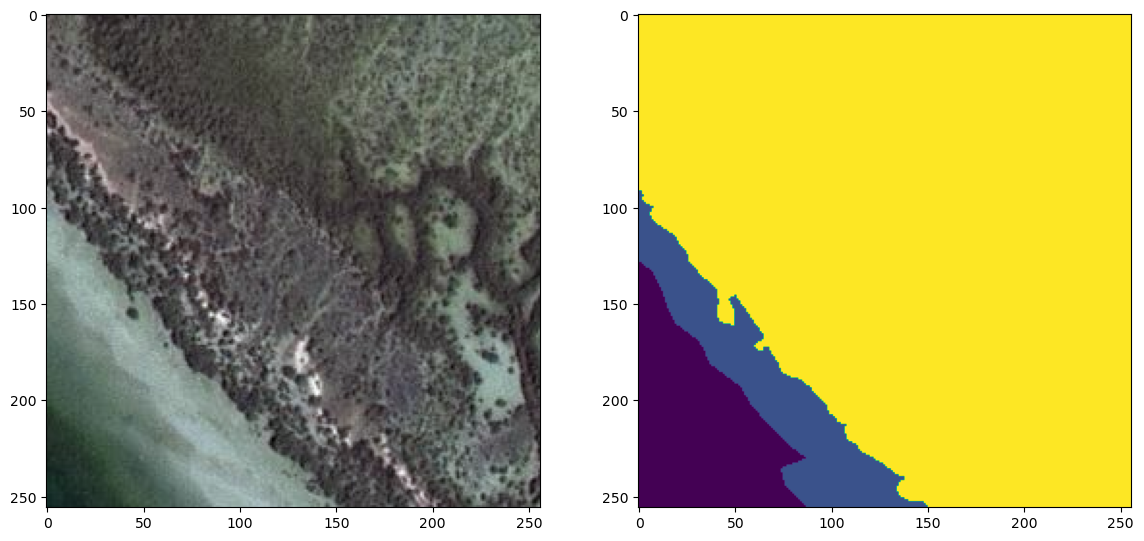

In [134]:
# render output based on labels 
random_image_id=random.randint(0,len(image_dataset))
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
# plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])
# print(labels[random_image_id])

# test and train dataset

In [135]:
master_training_dataset=image_dataset

In [136]:
total_classes=len(np.unique(labels))
total_classes

6

In [137]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [138]:
# create categorical variables 
labels_categorical_dataset=to_categorical(labels,num_classes=total_classes)

In [139]:
labels_categorical_dataset.shape,master_training_dataset.shape

((945, 256, 256, 6), (945, 256, 256, 3))

In [140]:
xtrain,xtest,ytrain,ytest=train_test_split(master_training_dataset,labels_categorical_dataset,test_size=0.15,random_state=100)

In [141]:
xtrain.shape,xtest.shape,ytrain.shape,ytest.shape

((803, 256, 256, 3),
 (142, 256, 256, 3),
 (803, 256, 256, 6),
 (142, 256, 256, 6))

In [142]:
image_height=xtrain.shape[1]
image_width=xtrain.shape[2]
image_channels=xtrain.shape[3]
total_classes=ytrain.shape[3]

In [143]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# PART 2 - modelling

- define layers
- evaluate layers
- jaccard Index/ intersection over union - evaluation matrics
- loss function - focal loss (cross entropy loss extension)
- diagnostics (plot loss)

In [144]:
from keras.models import Model
from keras.layers import Input,Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [145]:
from keras import backend as K # calculations - tensorflow

## evaluation metrics
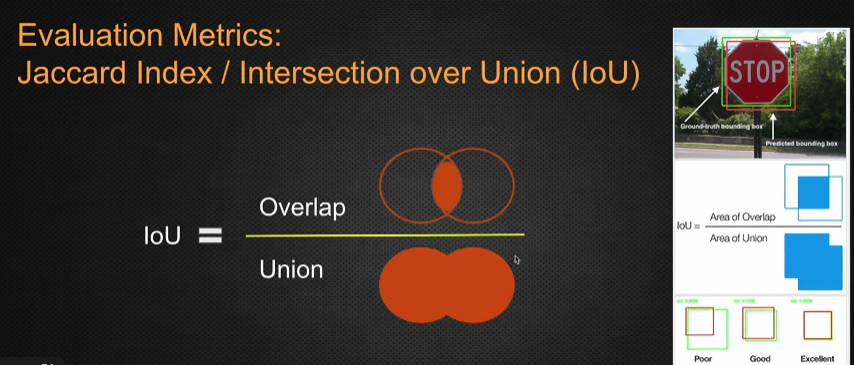

In [146]:
def jaccard_coeff(ytrue, ypred):
    ytrue_flatten=K.flatten(ytrue)
    ypred_flatten=K.flatten(ypred)
    intersection = K.sum(ytrue_flatten * ypred_flatten)
    final_coef_value=(intersection+1.0)/(K.sum(ytrue_flatten)+K.sum(ypred_flatten)-intersection+1.0)
    return final_coef_value

## u net architecture
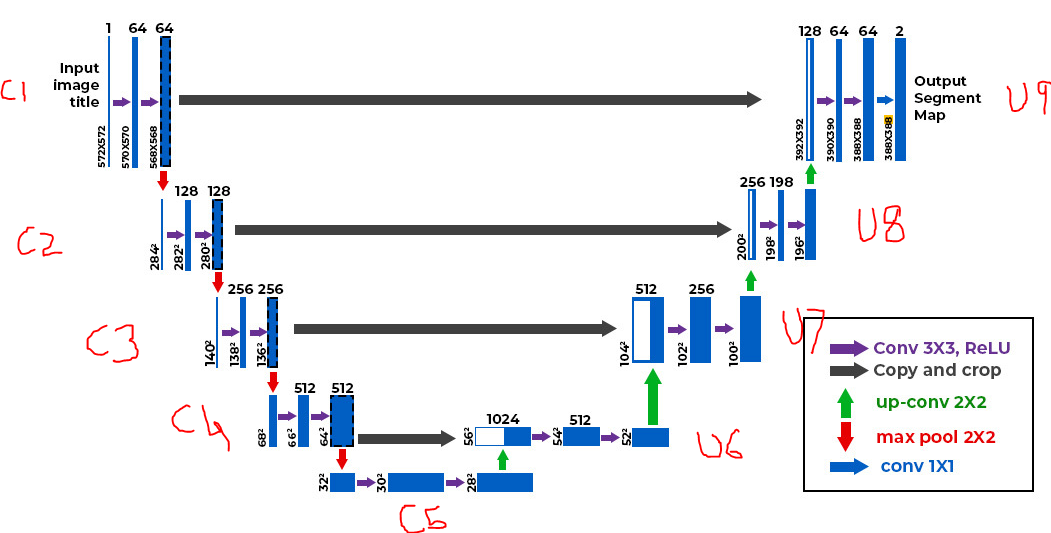

## netron - visualize any deep learning model 
- https://github.com/lutzroeder/netron

In [147]:
def multi_unet_model(n_classes=5,image_height=256,image_width=256,image_channels=1):

    inputs=Input((image_height,image_width,image_channels))
    source_input=inputs
    
    c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(source_input)
    c1=Dropout(0.2)(c1)
    c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
    p1=MaxPooling2D((2,2))(c1)

    c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
    c2=Dropout(0.2)(c2)
    c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
    p2=MaxPooling2D((2,2))(c2)

    c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
    c3=Dropout(0.2)(c3)
    c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
    p3=MaxPooling2D((2,2))(c3)

    c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
    c4=Dropout(0.2)(c4)
    c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
    p4=MaxPooling2D((2,2))(c4)

    c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
    c5=Dropout(0.2)(c5)
    c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)

    u6=Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
    u6=concatenate((u6,c4))
    c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
    c6=Dropout(0.2)(c6)
    c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

    u7=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
    u7=concatenate((u7,c3), axis=3)
    c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
    c7=Dropout(0.2)(c7)
    c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

    u8=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
    u8=concatenate((u8,c2))
    c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
    c8=Dropout(0.2)(c8)
    c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

    u9=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
    u9=concatenate((u9,c1))
    c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
    c9=Dropout(0.2)(c9)
    c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

    # output
    outputs=Conv2D(n_classes,(1,1),activation='softmax')(c9)
    model=Model(inputs=[inputs], outputs=[outputs])
    return model

In [148]:
metrics=['accuracy',jaccard_coeff]

In [149]:
def get_deep_learning_model():
    return multi_unet_model(
        n_classes=total_classes,
        image_height=image_height,
        image_width=image_width,
        image_channels=image_channels
    )

In [150]:
model=get_deep_learning_model()

In [151]:
model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'name': '

## Loss Function: Focal Loss (Cross Entropy Loss Extension)
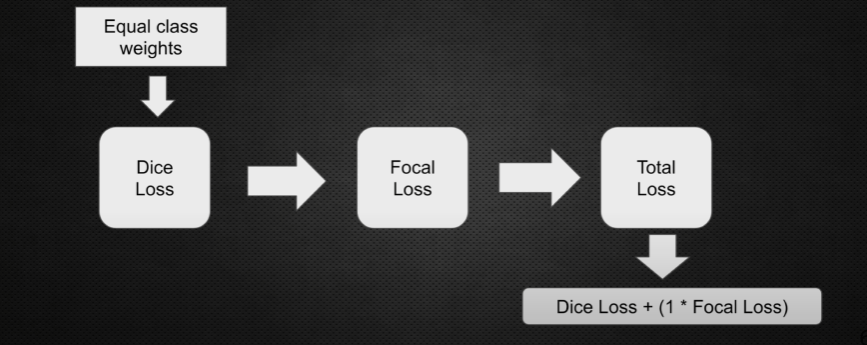

In [152]:
weights = [0.1666,0.1666,0.1666,0.1666,0.1666,0.1666]

# segmentation model
- https://github.com/qubvel/segmentation_models
- loss function to run during training

In [153]:
import segmentation_models as sm

In [154]:
dice_loss=sm.losses.DiceLoss(class_weights=weights)
focal_loss=sm.losses.CategoricalFocalLoss()
total_loss=dice_loss+(1*focal_loss)

## model compilation

In [155]:
import tensorflow as tf

In [156]:
tf.keras.backend.clear_session()

In [157]:
model.compile(optimizer='adam',loss=total_loss,metrics=metrics)

In [158]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [159]:
model_history=model.fit(xtrain,ytrain,
                        batch_size=16,
                        verbose=1,
                        epochs=100,
                        validation_data=(xtest,ytest),
                        shuffle=False
                       )

Epoch 1/100
51/51 [==============================] - 8s 134ms/step - loss: 1.0059 - accuracy: 0.5060 - jaccard_coeff: 0.2362 - val_loss: 0.9956 - val_accuracy: 0.5456 - val_jaccard_coeff: 0.2691
Epoch 2/100
51/51 [==============================] - 6s 124ms/step - loss: 0.9829 - accuracy: 0.6471 - jaccard_coeff: 0.3553 - val_loss: 0.9687 - val_accuracy: 0.7030 - val_jaccard_coeff: 0.4638
Epoch 3/100
51/51 [==============================] - 6s 125ms/step - loss: 0.9581 - accuracy: 0.7288 - jaccard_coeff: 0.4755 - val_loss: 0.9690 - val_accuracy: 0.6862 - val_jaccard_coeff: 0.4396
Epoch 4/100
51/51 [==============================] - 6s 125ms/step - loss: 0.9529 - accuracy: 0.7452 - jaccard_coeff: 0.4988 - val_loss: 0.9736 - val_accuracy: 0.6768 - val_jaccard_coeff: 0.4422
Epoch 5/100
51/51 [==============================] - 6s 125ms/step - loss: 0.9495 - accuracy: 0.7535 - jaccard_coeff: 0.5150 - val_loss: 0.9820 - val_accuracy: 0.6491 - val_jaccard_coeff: 0.4121
Epoch 6/100
51/51 [======

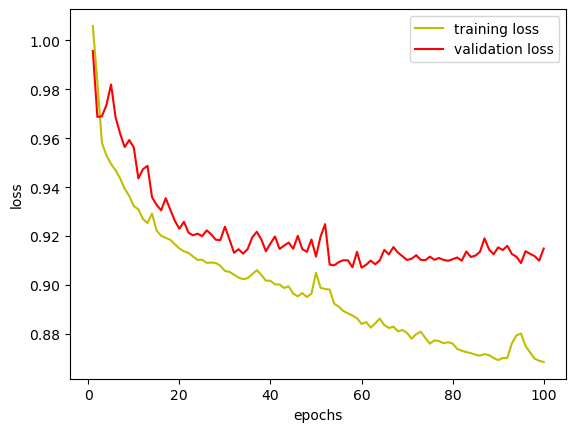

In [160]:
history_a=model_history
loss=history_a.history['loss']
val_loss=history_a.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='training loss')
plt.plot(epochs,val_loss,'r',label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [161]:
# history_a.history

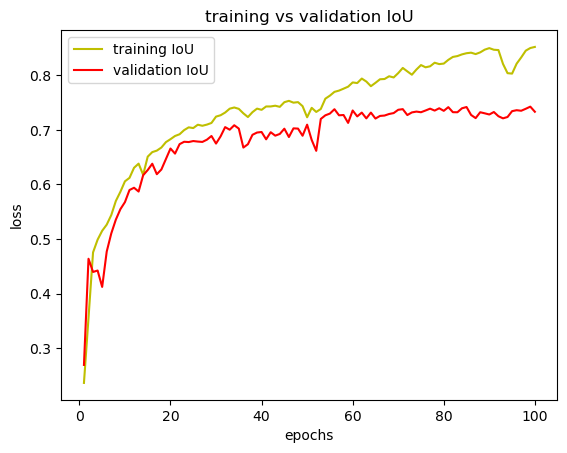

In [162]:
jaccard_coef=history_a.history['jaccard_coeff']
val_jaccard_coef=history_a.history['val_jaccard_coeff']
epochs=range(1,len(jaccard_coef)+1)
plt.plot(epochs,jaccard_coef,'y',label='training IoU')
plt.plot(epochs,val_jaccard_coef,'r',label='validation IoU')
plt.title('training vs validation IoU')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [163]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 51}

# perform predictions

In [164]:
y_pred=model.predict(xtest)

5/5 [==============================] - 0s 51ms/step


In [165]:
len(y_pred)

142

In [166]:
y_pred_argmax=np.argmax(y_pred,axis=3)

In [167]:
len(y_pred_argmax)

142

In [168]:
y_test_argmax=np.argmax(ytest,axis=3)

In [169]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

# comparing prediction results

In [191]:
test_image_number=random.randint(0,len(xtest))
test_image=xtest[test_image_number]
ground_truth_image=y_test_argmax[test_image_number]

test_image_input=np.expand_dims(test_image,0)

prediction=model.predict(test_image_input)
predicted_image=np.argmax(prediction,axis=3)
predicted_image=predicted_image[0,:,:]

1/1 [==============================] - 0s 22ms/step


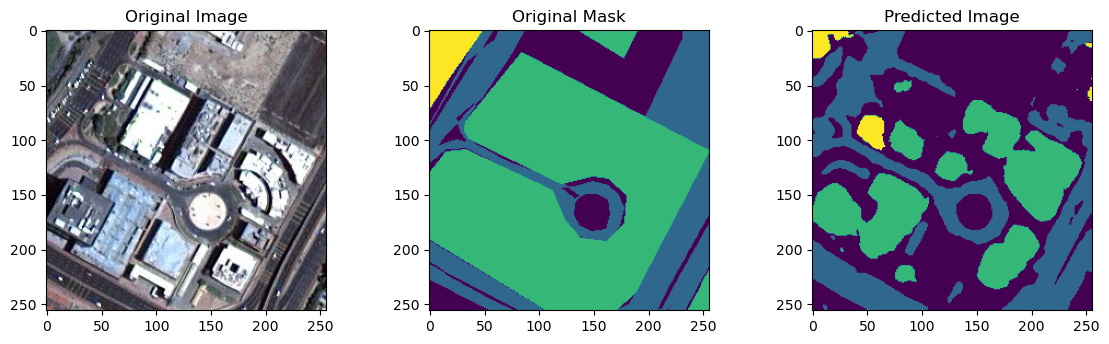

In [192]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(test_image)
plt.subplot(232)
plt.title('Original Mask')
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title('Predicted Image')
plt.imshow(predicted_image)

In [193]:
model.save('satellite_segmentation_full.h5')